In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
import os 
os.chdir("/content/drive/My Drive/fast.ai v3/section 2/cust_dl_lib")

!git config --global user.email "rajp152000@gmail.com"
!git config --global user.name "rajp152k"
!pip install fire
import fire
datasets_path = "/content/drive/My Drive/fast.ai v3/datasets"

In [0]:
#export 
from exps.nb_02 import *
import torch.nn.functional as F

# Setting up

Data

In [0]:
mpl.rcParams['image.cmap'] = 'gray'

In [0]:
x_train,y_train,x_valid,y_valid = get_data()

In [0]:
n,m = x_train.shape
c  = y_train.max() +1
nh = 50

In [0]:
class Model(nn.Module):
    def __init__(self,n_in,nh,n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh),nn.ReLU(),nn.Linear(nh,n_out)]

    def __call__(self,x):
        for l in self.layers:
            x = l(x)
        return x

In [0]:
model = Model(m,nh,10)

In [0]:
pred = model(x_train)

# Cross entropy


softmax activations :
$$ a_i = \frac{e^{x_i}}{\sum_{j=0}^{n-1}{e^{x_j}}} $$

computing the log of the softmax activations: 
 - to avoid computation of large numbers
 - computational stability trick


In [0]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

keeping dimension for efficient future broadcasting

In [0]:
sm_pred = log_softmax(pred)

cross entropy loss for some prediction target x's prediction p(x) is given by :
$$ L(p(x)) = -\sum {x log(p(x))}$$

negative log loss

In [74]:
sm_pred[:5], sm_pred.shape

(tensor([[-2.2610, -2.4201, -2.2800, -2.2694, -2.3461, -2.3754, -2.2766, -2.2853,
          -2.3337, -2.1969],
         [-2.2601, -2.2488, -2.2737, -2.2633, -2.4757, -2.4595, -2.2411, -2.3624,
          -2.2770, -2.2029],
         [-2.2812, -2.2861, -2.4077, -2.2407, -2.3752, -2.3507, -2.2262, -2.3179,
          -2.3165, -2.2403],
         [-2.3403, -2.3412, -2.3392, -2.2364, -2.3346, -2.4182, -2.1354, -2.3050,
          -2.3527, -2.2515],
         [-2.3115, -2.3064, -2.3810, -2.3080, -2.3561, -2.3607, -2.0898, -2.3874,
          -2.3270, -2.2346]], grad_fn=<SliceBackward>),
 torch.Size([50000, 10]))

In [75]:
y_train.shape[0]

50000

using boolean indexing

In [0]:
def nll(input,target): return -input[range(target.shape[0]),target].mean()

In [0]:
loss = nll(sm_pred,y_train)

In [78]:
loss

tensor(2.2932, grad_fn=<NegBackward>)

mathematical refactoring

In [0]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

using broadcasting above ( due to keeping dimension )

In [0]:
test_near(nll(log_softmax(pred),y_train),loss)

increasing computational stability by using the LogSumExp trick :
https://en.wikipedia.org/wiki/LogSumExp

In [81]:
pred.shape

torch.Size([50000, 10])

In [82]:
pred.max(-1)

torch.return_types.max(values=tensor([0.1128, 0.1001, 0.1136,  ..., 0.1344, 0.1163, 0.1978],
       grad_fn=<MaxBackward0>), indices=tensor([9, 9, 6,  ..., 6, 6, 6]))

In [0]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m+(x-m[:,None]).exp().sum(-1).log()

avoids overflow: Pytorch already does this

In [0]:
test_near(logsumexp(pred),pred.logsumexp(-1))

second one's from pytorch

In [0]:
def log_softmax(x): return x  - x.logsumexp(-1,keepdim=True)

In [0]:
test_near(nll(log_softmax(pred),y_train),loss)

In [0]:
test_near(F.nll_loss(F.log_softmax(pred,-1),y_train),loss)

cross_entropy simply combines the two

In [0]:
test_near(F.cross_entropy(pred,y_train),loss)

# Basic training loop

actions:
 - calculate preds
 - compute loss
 - calculate grads
 - update params

In [0]:
loss_func = F.cross_entropy

In [0]:
#export 
def accuracy(out,yb): return ((torch.argmax(out,dim=1)==yb).
                              float().
                              mean())

In [91]:
bs = 64 # batch size

xb = x_train[0:bs]
preds = model(xb)
print(preds[0])
print(preds.shape)

tensor([ 0.0486, -0.1105,  0.0297,  0.0403, -0.0364, -0.0657,  0.0331,  0.0244,
        -0.0240,  0.1128], grad_fn=<SelectBackward>)
torch.Size([64, 10])


In [0]:
yb = y_train[:bs]

In [93]:
loss_func(preds,yb)

tensor(2.2925, grad_fn=<NllLossBackward>)

In [94]:
accuracy(preds,yb)

tensor(0.0781)

near 10 percent: as expected

In [0]:
lr = 0.5
epochs = 1

In [0]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb = x_train[i*bs:i*bs+bs]
        yb = y_train[i*bs:i*bs+bs]

        loss = loss_func(model(xb),yb)

        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l,'weight'):
                    l.weight -= l.weight.grad*lr
                    l.bias -= l.bias.grad*lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()

In [97]:
loss_func(model(xb),yb),accuracy(model(xb),yb)

(tensor(0.2312, grad_fn=<NllLossBackward>), tensor(0.9375))

# Parameters and optim

moving relu to functional so that don't have to check if a layer has parameters <br>
using nn.Module.\_\_setattr__

In [0]:
class Model(nn.Module):
    def __init__(self,n_in,nh,n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)

    def __call__(self,x) : 
        return self.l2(F.relu(self.l1(x)))

In [0]:
model = Model(m,nh,10)

In [100]:
help(model.named_children)

Help on method named_children in module torch.nn.modules.module:

named_children() method of __main__.Model instance
    Returns an iterator over immediate children modules, yielding both
    the name of the module as well as the module itself.
    
    Yields:
        (string, Module): Tuple containing a name and child module
    
    Example::
    
        >>> for name, module in model.named_children():
        >>>     if name in ['conv4', 'conv5']:
        >>>         print(module)



In [101]:
for name,l in model.named_children(): print(f"{name}:{l}") 

l1:Linear(in_features=784, out_features=50, bias=True)
l2:Linear(in_features=50, out_features=10, bias=True)


In [102]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [103]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [0]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            xb = x_train[i*bs:i*bs+bs]
            yb = y_train[i*bs:i*bs+bs]

            loss = loss_func(model(xb),yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():p-=p.grad*lr
                model.zero_grad()

In [105]:
fit()
loss_func(model(xb),yb),accuracy(model(xb),yb)

(tensor(0.1553, grad_fn=<NllLossBackward>), tensor(0.9375))

improvising : making parameters yieldable <br>
i.e. adding some pytorch like functionality

In [0]:
class Buffer_Module():
    def __init__(self,n_in,nh,n_out):
        self._modules={}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
    def __setattr__(self,k,v):
        if not k.startswith("_") : self._modules[k] = v
        super().__setattr__(k,v)
        # avoid recursive calls by excluding ones starting
        # with _
    def __repr__(self):
        return f'{self._modules}'
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters():yield p

In [107]:
mdl = Buffer_Module(m,nh,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

\_\_repr__ in action

In [111]:
[param.shape for param in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

nn.ModuleList implements the \_\_setattr__ functionality 

In [0]:
class SequentialModel(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)

    def __call__(self,x):
        for l in self.layers:
            x = l(x)
        return x
    

In [0]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]
model = SequentialModel(layers)

In [117]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [0]:
fit()

In [119]:
loss_func(model(xb),yb),accuracy(model(xb),yb)

(tensor(0.1163, grad_fn=<NllLossBackward>), tensor(0.9375))

# nn.Sequential

In [0]:

model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [0]:
fit()

In [125]:
loss_func(model(xb),yb),accuracy(model(xb),yb)

(tensor(0.1031, grad_fn=<NllLossBackward>), tensor(0.9375))

implemented the Sequential class <br>
can use it from now onwards

In [127]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [0]:
nn.Sequential??

refactoring the optimizer in one class

# optim

gaining the following functionality:
 - opt.step()
 - opt.zero_grad()


In [0]:
class Optimizer():
    def __init__(self,params,lr=0.5):
        self.params = list(params)
        self.lr = lr
    def step(self):
            with torch.no_grad():
                for p in self.params: p-=p.grad*lr
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [0]:
model = nn.Sequential(nn.Linear(m,nh),
                      nn.ReLU(),
                      nn.Linear(nh,10))

In [0]:
opt = Optimizer(model.parameters())

In [0]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb = x_train[bs*i :bs*i +bs ]
        yb = y_train[bs*i :bs*i +bs ]
        loss = loss_func(model(xb),yb)
        loss.backward()
        opt.step()
        opt.zero_grad()

In [0]:
loss,acc = loss_func(model(xb),yb),accuracy(model(xb),yb)

gained some functionality from Optim.SGD ( some, cause yet to implement features like:
  - momentum 
  - weight decay
  - annealing and so on
)


In [0]:
#export 
from torch import optim

In [0]:
optim.SGD??

## Beginning to test the waters for the DataBunch API

making the manual assignments of the minibatches easier on the eye

In [0]:
#export 
class Dataset():
    def __init__(self,x,y): 
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self,i):
        return self.x[i],self.y[i]

In [0]:
train_ds,valid_ds = Dataset(x_train,y_train),Dataset(x_valid,y_valid)

tensor(5)


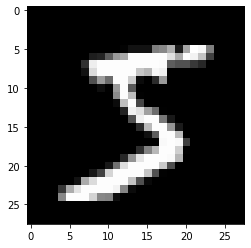

In [164]:
img,lbl = train_ds[0]
plt.imshow(img.view(28,28))
print(lbl)

In [0]:
assert(len(train_ds) == len(x_train))
assert(len(valid_ds) == len(x_valid))

In [0]:
xb,yb = train_ds[0:5]

In [155]:
assert xb.shape==(5,28*28) and len(yb)==5
xb,yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

implementing the data loader to handle batch sizes

In [0]:
class DataLoader():
    def __init__(self,ds,bs):
        self.ds = ds
        self.bs = bs
    def __iter__(self):# iterability
        for i in range(0,len(self.ds),self.bs):
            yield self.ds[i:i+bs]

In [0]:
train_dl = DataLoader(train_ds,bs)
valid_dl = DataLoader(valid_ds,bs) 

In [0]:
xb,yb = next(iter(valid_dl))
assert xb.shape ==(bs,28*28) and yb.shape==(bs,)

In [0]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh),nn.ReLU(),nn.Linear(nh,10))
    return model,optim.SGD(model.parameters(),lr=lr)

In [0]:
model,opt = get_model()

In [0]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            loss = loss_func(model(xb),yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [0]:
fit()

In [200]:
loss,acc = loss_func(model(xb),yb),accuracy(model(xb),yb)
print(loss)
print(acc)

tensor(0.0298, grad_fn=<NllLossBackward>)
tensor(0.9844)


# Randomizing the data fetching process

only for the training set and not the validation set

In [0]:
class Sampler():
    def __init__(self,ds,bs,shuffle=False):
        self.n = len(ds)
        self.bs = bs
        self.shuffle = shuffle
    def __iter__(self):
        # creating remapped indexes rather than the data itself
        if self.shuffle:
            self.idxs = torch.randperm(self.n)
        else :
            self.idxs = torch.arange(self.n)
        for i in range(0,self.n,self.bs):
            yield self.idxs[i:i+self.bs]

In [0]:
small_ds = Dataset(*train_ds[:10])

In [208]:
# testing the sampler
s = Sampler(small_ds,3,False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [209]:
s = Sampler(small_ds,3,True)
[o for o in s]

[tensor([9, 1, 4]), tensor([0, 6, 8]), tensor([2, 5, 7]), tensor([3])]

working as expected

# compiling chronologically

In [0]:
def comp_chron(b):
    # chronological compilation
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

class DataLoader():
    def __init__(self,ds,sampler,comp_chron_fn=comp_chron):
        self.ds = ds
        self.sampler= sampler
        self.comp_chron_fn = comp_chron

    def __iter__(self):
        for s in self.sampler: 
            yield self.comp_chron_fn([self.ds[i] for i in s])

In [0]:
train_samp = Sampler(train_ds,bs,shuffle=True)
valid_samp = Sampler(valid_ds,bs,shuffle=False)
# not shuffling validation set

In [0]:
train_dl = DataLoader(train_ds,
                      sampler=train_samp,
                      comp_chron_fn=comp_chron)
valid_dl = DataLoader(valid_ds,
                      sampler=valid_samp,
                      comp_chron_fn=comp_chron)

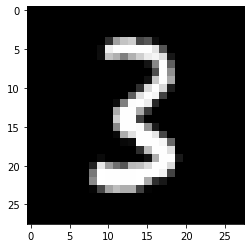

In [214]:
xb,yb  = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))

## Gained Functionality

# The Pytorch DataLoader

In [0]:
#export 
from torch.utils.data import DataLoader,SequentialSampler,RandomSampler

In [0]:
train_dl = DataLoader(train_ds,bs,
                      sampler=RandomSampler(train_ds),
                      collate_fn = comp_chron)
valid_dl = DataLoader(valid_ds,bs,
                      sampler=SequentialSampler(valid_ds),
                      collate_fn=comp_chron)

In [218]:
model,opt = get_model()
fit()
loss_func(model(xb),yb),accuracy(model(xb),yb)

(tensor(0.0899, grad_fn=<NllLossBackward>), tensor(0.9688))

testing pytorch's defaults 

In [0]:
train_dl = DataLoader(train_ds,bs,shuffle=True,drop_last=True)
valid_dl = DataLoader(valid_ds,bs,shuffle=False)

In [0]:
help(DataLoader)
# lookup what drop_last does: ignores last fetch if not 
# equal to the batch size

Help on class DataLoader in module torch.utils.data.dataloader:

class DataLoader(builtins.object)
 |  Data loader. Combines a dataset and a sampler, and provides an iterable over
 |  the given dataset.
 |  
 |  The :class:`~torch.utils.data.DataLoader` supports both map-style and
 |  iterable-style datasets with single- or multi-process loading, customizing
 |  loading order and optional automatic batching (collation) and memory pinning.
 |  
 |  See :py:mod:`torch.utils.data` documentation page for more details.
 |  
 |  Arguments:
 |      dataset (Dataset): dataset from which to load the data.
 |      batch_size (int, optional): how many samples per batch to load
 |          (default: ``1``).
 |      shuffle (bool, optional): set to ``True`` to have the data reshuffled
 |          at every epoch (default: ``False``).
 |      sampler (Sampler, optional): defines the strategy to draw samples from
 |          the dataset. If specified, :attr:`shuffle` must be ``False``.
 |      batch_s

In [223]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb),yb),accuracy(model(xb),yb)
loss,acc

(tensor(0.1335, grad_fn=<NllLossBackward>), tensor(0.9531))

# implementing Validation

In [0]:
def fit(epochs,model,loss_func,opt,train_dl,valid_dl):
    for epoch in range(epochs):
        
        model.train()
        for xb,yb in train_dl:
            loss = loss_func(model(xb),yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        model.eval()
        with torch.no_grad():
            loss_sum,acc_sum = 0.,0.
            for xb,yb in valid_dl:
                preds = model(xb)
                loss_sum+= loss_func(preds,yb)
                acc_sum+= accuracy(preds,yb)
        lv = len(valid_dl)
        print(epoch,loss_sum/lv,acc_sum/lv)
    return loss_sum/lv,acc_sum/lv


        

In [0]:
#export 
def get_dls(train_ds,valid_ds,bs,**kwargs):
    train_dl = DataLoader(train_ds,bs,shuffle=True,**kwargs)
    valid_dl = DataLoader(valid_ds,bs*2,**kwargs)
    return train_dl,valid_dl

bs*2 for the validation dataloader to use resources to max extent

In [232]:
train_dl,valid_dl = get_dls(train_ds,valid_ds,bs)
model,opt = get_model()
loss_acc = fit(5,model,loss_func,opt,train_dl,valid_dl)

0 tensor(0.1837) tensor(0.9442)
1 tensor(0.1370) tensor(0.9589)
2 tensor(0.1107) tensor(0.9664)
3 tensor(0.1047) tensor(0.9705)
4 tensor(0.1187) tensor(0.9674)


that's some serious refactoring 

Exporting

In [233]:
!python notebook2script.py 03_batches.ipynb

Converted 03_batches.ipynb to exps/nb_03.py


In [234]:
!git add .
!git commit -m "Batches"
!git push

[master 1e5b93c] Batches
 5 files changed, 33 insertions(+), 2 deletions(-)
 create mode 100644 03_batches.ipynb
 create mode 100644 exps/__pycache__/nb_02.cpython-36.pyc
 create mode 100644 exps/nb_03.py
Counting objects: 9, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (9/9), done.
Writing objects: 100% (9/9), 21.37 KiB | 2.67 MiB/s, done.
Total 9 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/rajp152k/cust_dl_lib.git
   e6579cc..1e5b93c  master -> master
